Dataset Shape: (32561, 15)

Data Types:
 age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

Missing Values:
 age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

Summary Statistics:
                  age workclass        fnlwgt education  education_num  \
count   32561.000000     32561  3.256100e+04     32561   32561.000000   
unique           NaN         9           NaN        16            NaN  

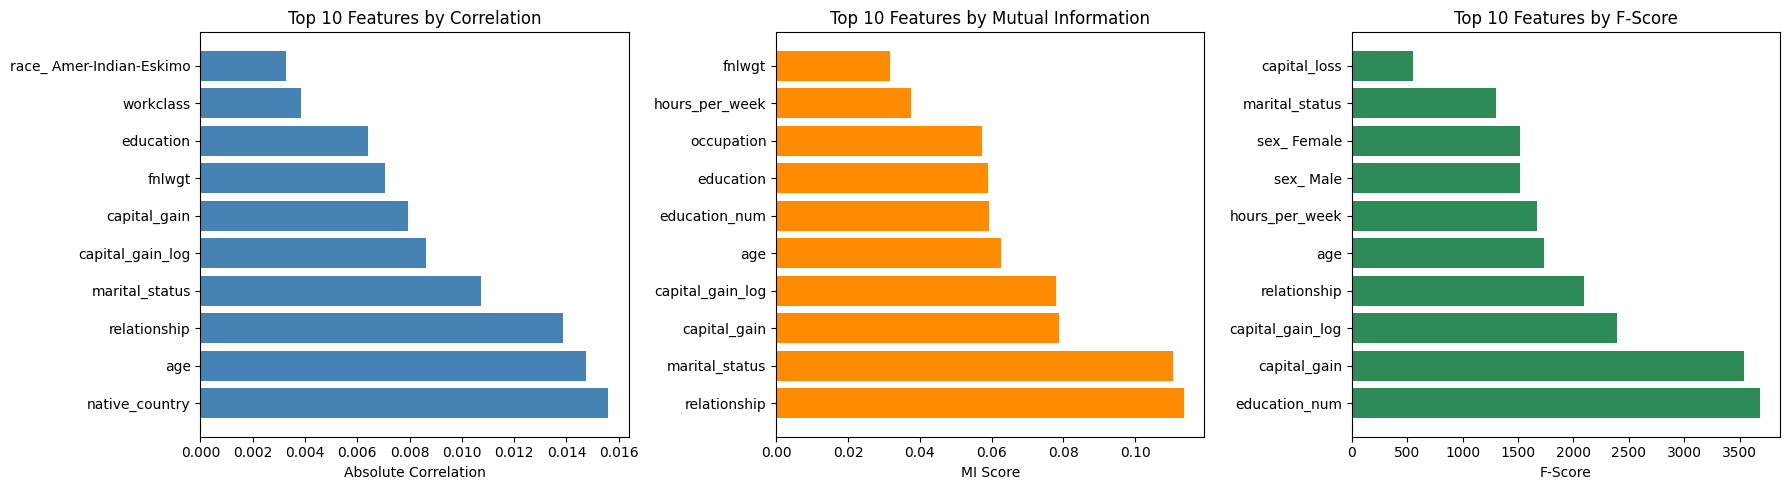

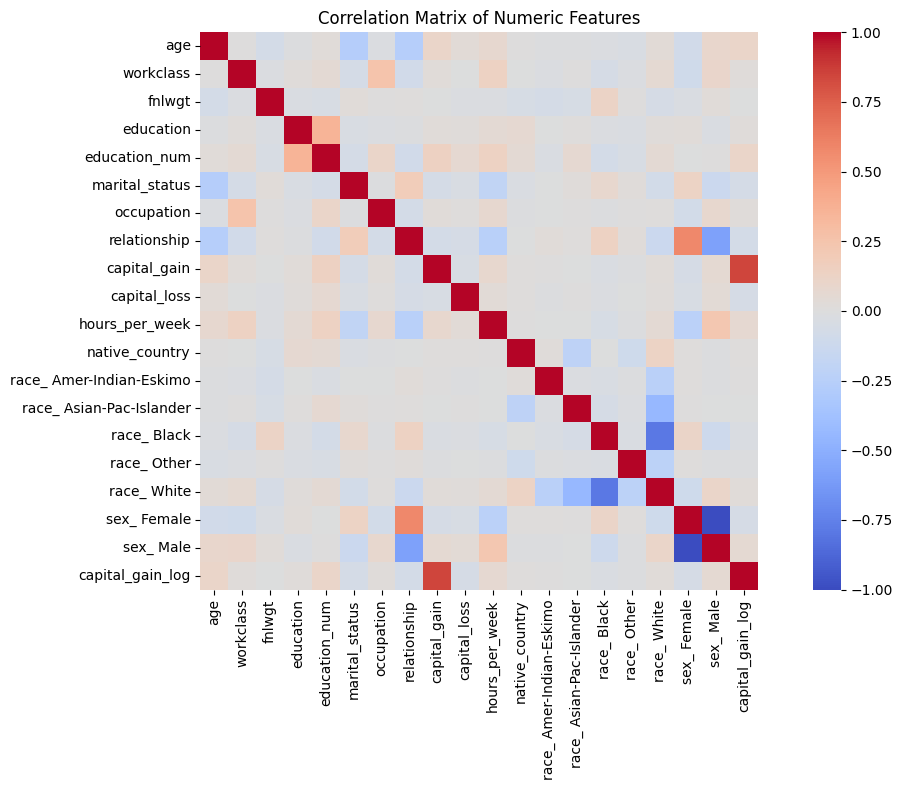


Feature Selection Methods Comparison:
- Correlation: Captures linear relationships, fast computation.
- Mutual Information: Captures non-linear relationships, more powerful but computationally expensive.
- F-Score: Measures statistical significance of each feature, useful for ANOVA-based selection.


In [8]:
# Full pipeline for Adult dataset preprocessing, feature engineering, and feature selection
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import mutual_info_classif, f_classif
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# 1. Load and Explore Dataset
# -----------------------------

df = pd.read_csv("C:/Users/Shreyas Mahale/Downloads/EDA2/EDA2/adult_with_headers.csv")

print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nSummary Statistics:\n", df.describe(include='all'))

# -----------------------------
# 2. Handle Missing Values
# -----------------------------
# Replace '?' with NaN for categorical columns
df.replace("?", np.nan, inplace=True)

# Drop rows with missing values (alternative: imputation)
df.dropna(inplace=True)
print("\nAfter handling missing values, shape:", df.shape)

# -----------------------------
# 3. Scaling Numerical Features
# -----------------------------
num_features = df.select_dtypes(include=['int64', 'float64']).columns

# Standard Scaling
scaler_std = StandardScaler()
df_std = df.copy()
df_std[num_features] = scaler_std.fit_transform(df_std[num_features])

# Min-Max Scaling
scaler_mm = MinMaxScaler()
df_mm = df.copy()
df_mm[num_features] = scaler_mm.fit_transform(df_mm[num_features])

print("\nStandard Scaling Example:\n", df_std[num_features].head())
print("\nMin-Max Scaling Example:\n", df_mm[num_features].head())

# Discussion:
# - Standard Scaling is preferred when features follow Gaussian distribution (e.g., linear models, PCA).
# - Min-Max Scaling is useful when features have arbitrary distributions or when using algorithms sensitive to magnitude (e.g., neural networks, distance-based models).

# -----------------------------
# 4. Encoding Categorical Features
# -----------------------------
cat_features = df.select_dtypes(include=['object']).columns
df_encoded = df.copy()

for col in cat_features:
    if df_encoded[col].nunique() <= 5:
        # One-Hot Encoding
        df_encoded = pd.get_dummies(df_encoded, columns=[col], prefix=col)
    else:
        # Label Encoding
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])

print("\nEncoded Data Shape:", df_encoded.shape)

# Pros & Cons:
# - One-Hot Encoding: Pros – no ordinal assumption, Cons – dimensionality explosion.
# - Label Encoding: Pros – compact, Cons – may introduce artificial ordinal relationships.

# -----------------------------
# 5. Feature Engineering
# -----------------------------
df_fe = df_encoded.copy()

# Example Feature 1: Age bucket
df_fe['age_bucket'] = pd.cut(df_fe['age'], bins=[0,25,45,65,100], labels=['Young','Adult','Mid-age','Senior'])

# Example Feature 2: Hours-per-week category
df_fe['work_hours_category'] = pd.cut(df_fe['hours_per_week'], bins=[0,20,40,60,100], labels=['Part-time','Full-time','Overtime','Extreme'])

# Transformation: Log transform skewed feature (capital-gain)
df_fe['capital_gain_log'] = np.log1p(df_fe['capital_gain'])

print("\nFeature Engineering Done. New Features Added:", ['age_bucket','work_hours_category','capital_gain_log'])

# -----------------------------
# 6. Feature Selection using Correlation & Mutual Information
# -----------------------------
# Isolation Forest for outlier detection
iso = IsolationForest(contamination=0.02, random_state=42)
outliers = iso.fit_predict(df_fe[num_features])
df_fe = df_fe[outliers == 1]  # Keep only non-outliers

# Prepare target variable (assuming binary classification target exists)
# Identify target column (common names: 'income', 'target', 'label')
target_cols = [col for col in df_fe.columns if 'income' in col.lower() or 'target' in col.lower()]
if target_cols:
    target_col = target_cols[0]
    
    # Extract numeric target
    if df_fe[target_col].dtype == 'object':
        le_target = LabelEncoder()
        y = le_target.fit_transform(df_fe[target_col])
    else:
        y = df_fe[target_col].values
    
    # Get feature columns (exclude target)
    X = df_fe.drop(columns=target_cols + ['age_bucket', 'work_hours_category'])
    
    # Ensure all features are numeric
    X_numeric = X.select_dtypes(include=['int64', 'float64', 'bool'])
    
    # Correlation with target
    correlations = pd.DataFrame({
        'Feature': X_numeric.columns,
        'Correlation': [X_numeric[col].corr(pd.Series(y)) for col in X_numeric.columns]
    })
    correlations['Abs_Correlation'] = correlations['Correlation'].abs()
    correlations = correlations.sort_values('Abs_Correlation', ascending=False)
    
    print("\nTop Features by Correlation with Target:\n", correlations.head(10))
    
    # Mutual Information with target
    mi_scores = mutual_info_classif(X_numeric, y, random_state=42)
    mi_df = pd.DataFrame({
        'Feature': X_numeric.columns,
        'Mutual_Information': mi_scores
    }).sort_values('Mutual_Information', ascending=False)
    
    print("\nTop Features by Mutual Information with Target:\n", mi_df.head(10))
    
    # F-statistic for feature selection
    f_scores, _ = f_classif(X_numeric, y)
    f_df = pd.DataFrame({
        'Feature': X_numeric.columns,
        'F_Score': f_scores
    }).sort_values('F_Score', ascending=False)
    
    print("\nTop Features by F-Score with Target:\n", f_df.head(10))
    
    # Visualize feature importance
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    axes[0].barh(correlations['Feature'].head(10), correlations['Abs_Correlation'].head(10), color='steelblue')
    axes[0].set_title('Top 10 Features by Correlation')
    axes[0].set_xlabel('Absolute Correlation')
    
    axes[1].barh(mi_df['Feature'].head(10), mi_df['Mutual_Information'].head(10), color='darkorange')
    axes[1].set_title('Top 10 Features by Mutual Information')
    axes[1].set_xlabel('MI Score')
    
    axes[2].barh(f_df['Feature'].head(10), f_df['F_Score'].head(10), color='seagreen')
    axes[2].set_title('Top 10 Features by F-Score')
    axes[2].set_xlabel('F-Score')
    
    plt.tight_layout()
    plt.show()
    
    # Correlation heatmap
    plt.figure(figsize=(12, 8))
    corr_matrix = X_numeric.corr()
    sns.heatmap(corr_matrix, cmap="coolwarm", center=0, square=True)
    plt.title("Correlation Matrix of Numeric Features")
    plt.tight_layout()
    plt.show()
    
    print("\nFeature Selection Methods Comparison:")
    print("- Correlation: Captures linear relationships, fast computation.")
    print("- Mutual Information: Captures non-linear relationships, more powerful but computationally expensive.")
    print("- F-Score: Measures statistical significance of each feature, useful for ANOVA-based selection.")
else:
    print("No target column found. Please check your dataset structure.")


In [2]:
if 'hours-per-week' in df.columns:
    df['work_hours_category'] = pd.cut(df['hours-per-week'], bins=[0,20,40,60,100], labels=['Part-time','Full-time','Overtime','Extreme'])
else:
    print("Column 'hours-per-week' not found. Available columns:", df.columns.tolist())

Column 'hours-per-week' not found. Available columns: ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']
